# Sprawozdanie z cw.2 Antoni Kois gr.2

In [1]:
!pip3 install openpyxl seaborn scikit-learn statsmodels
import pandas as pd

# Wczytanie danych z pliku
df = pd.read_excel('../cw1/dane_przekrojowe_przykład.xlsx')

# Podstawowe statystyki opisowe
print(df.describe())

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Applications/Xcode.app/Contents/Developer/usr/bin/python3 -m pip install --upgrade pip' command.
               year          price        mileage           tax           mpg  \
count  10668.000000   10668.000000   10668.000000  10668.000000  10668.000000   
mean    2017.100675   22896.685039   24827.244001    126.011436     50.770022   
std        2.167494   11714.841888   23505.257205     67.170294     12.949782   
min     1997.000000    1490.000000       1.000000      0.000000     18.900000   
25%     2016.000000   15130.750000    5968.750000    125.000000     40.900000   
50%     2017.000000   20200.000000   19000.000000    145.000000     49.600000   
75%     2019.000000   27990.000000   36464.500000    145.000000     58.900000   
max     2020.000000  145000.000000  323000.000000    580.000000    188.300000   

         engineSize  
count  10668.000000  
mean       

# Zadanie 1. Przygotowanie danych

### 1.1
Na podstawie współczynników zmienności i współczynników korelacji ocenić, czy któreś ze
zmiennych (wszystkich dostępnych) powinny zostać wyeliminowane przed przystąpieniem do
budowy modelu ekonometrycznego.

### 1.2
Zmodyfikować dostępny zbiór danych (rozważyć przekształcenia zmiennych, eliminację pewnych
obserwacji).

### 1.3
Dokonać podziału zbioru danych na zbiór uczący (90% obserwacji) i testowy (10% obserwacji).
Porównać statystyki na zbiorze uczącym i testowym. W jakim celu wykonywany jest ten podział? 


Współczynniki zmienności dla naszego zbioru:
year          0.001075
price         0.511615
mileage       0.946708
tax           0.533024
mpg           0.255056
engineSize    0.312283
dtype: float64


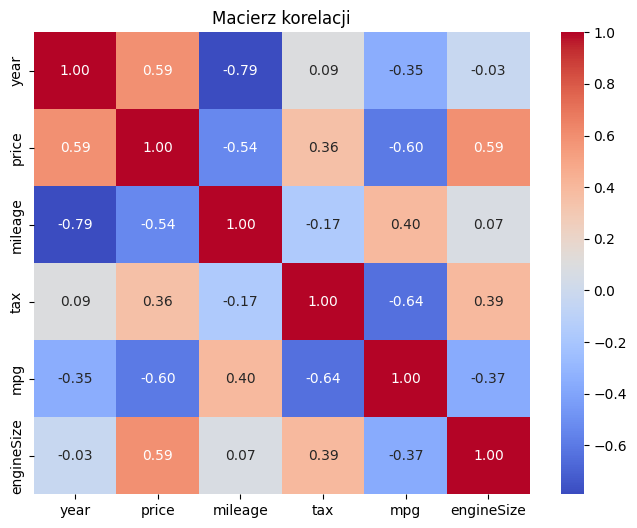

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import variation
from sklearn.model_selection import train_test_split
import statsmodels.api as sm

# Obliczenie współczynników zmienności
num_cols = ['year', 'price', 'mileage', 'tax', 'mpg', 'engineSize']
cv = df[num_cols].apply(lambda x: variation(x, nan_policy='omit'))
print("\nWspółczynniki zmienności dla naszego zbioru:")
print(cv)

# Obliczenie macierzy korelacji aby sprawdzić jak łątwiej sprawdzić jak one wyglądają
correlation_matrix = df[num_cols].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Macierz korelacji")
plt.show()

In [3]:
# Usuwanie obserwacji odstających na podstawie ceny (5 i 95 percentyl)
lower, upper = df['price'].quantile([0.05, 0.95])
df = df[(df['price'] >= lower) & (df['price'] <= upper)]

# Usunięcie obserwacji, gdzie engineSize = 0, ponieważ jest to prawdopodobnie zastąpienie wartości NaN
df = df[df['engineSize'] > 0]

# Dodanie nowej kolumny - wiek samochodu. Gdyż poprostu dla roku współczynnik zmienności jest mały i bez senus jest go porównywać
df['car_age'] = 2025 - df['year']
df.drop(columns=['year'], inplace=True)  # Usunięcie kolumny 'year', nie jest już nam potrzebna

# Usunięcie zmiennej 'mileage' (zbyt duża korelacja z rokiem, więc zostawiamy tylko jedną zmienną objaśniającą z tych dwóch)
df.drop(columns=['mileage'], inplace=True)

# Usunięcie wierszy, gdzie fuelType = Hybrid, gdyż wyraźnie widać, że tych aut ilościowo jest sporo mniej
df = df[df['fuelType'] != 'Hybrid']

# Usunięcie kolumny 'model', gdyż jest zmienną kategoryczną i ma zbyt wiele różnych wartości. Albo można "model" połączyć w mniejsze grupy i wtedy zmienić na faktory
df.drop(columns=['model'], inplace=True)

# Konwersja zmiennych kategorycznych na numeryczne (faktory)
df = pd.get_dummies(df, columns=['transmission', 'fuelType'], drop_first=True)

# Ponowne Sprawdzenie współczynników zmienności
num_cols = ['price', 'tax', 'mpg', 'engineSize', 'car_age']
cv = df[num_cols].apply(lambda x: variation(x, nan_policy='omit'))
print("\nWspółczynniki zmienności:")
print(cv)

# sprawdzenie czy nie ma kolumn kategorycznych
df.info()


Współczynniki zmienności:
price         0.358688
tax           0.501811
mpg           0.215384
engineSize    0.264691
car_age       0.230671
dtype: float64
<class 'pandas.core.frame.DataFrame'>
Index: 9536 entries, 0 to 10667
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   price                   9536 non-null   int64  
 1   tax                     9536 non-null   int64  
 2   mpg                     9536 non-null   float64
 3   engineSize              9536 non-null   float64
 4   car_age                 9536 non-null   int64  
 5   transmission_Manual     9536 non-null   bool   
 6   transmission_Semi-Auto  9536 non-null   bool   
 7   fuelType_Petrol         9536 non-null   bool   
dtypes: bool(3), float64(2), int64(3)
memory usage: 474.9 KB


In [4]:
# Konwersja bool na int, ponieważ metoda OLS nie przyjmuje typu boolean
df[df.select_dtypes(['bool']).columns] = df.select_dtypes(['bool']).astype(int)

# Podział na zbiór uczący i testowy
train_df, test_df = train_test_split(df, test_size=0.1, random_state=42)

# Porównanie statystyk zbiorów
print("\nStatystyki zbioru uczącego:")
print(train_df.describe())
print("\nStatystyki zbioru testowego:")
print(test_df.describe())


# Budowa modelu ekonometrycznego
X_train = train_df.drop(columns=['price'])
X_train[X_train.select_dtypes(['bool']).columns] = X_train.select_dtypes(['bool']).astype(int)  # Konwersja bool na int
y_train = train_df['price']
X_train = sm.add_constant(X_train)  # Dodanie stałej do modelu, w R funckja lm jest dodawan pod spodem w trakcie
model = sm.OLS(y_train, X_train).fit()

# Podsumowanie modelu
print(model.summary())

# Przetestowanie na danych testowych
X_test = test_df.drop(columns=['price'])
y_test = test_df['price']
X_test = sm.add_constant(X_test)  # Dodanie stałej
y_pred = model.predict(X_test)

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Średni błąd bezwzględny - Mean Absolute Error (MAE): {mae}")
print(f"Średni błąd kwadratowy - Mean Squared Error (MSE): {mse}")
print(f"R²: {r2}")



Statystyki zbioru uczącego:
              price          tax          mpg   engineSize      car_age  \
count   8582.000000  8582.000000  8582.000000  8582.000000  8582.000000   
mean   21813.854230   126.040550    50.921277     1.874878     7.737357   
std     7849.248309    63.516488    10.984842     0.496282     1.785620   
min     9950.000000     0.000000    20.300000     1.000000     5.000000   
25%    15798.000000   125.000000    42.200000     1.500000     6.000000   
50%    20003.500000   145.000000    50.400000     2.000000     8.000000   
75%    26990.000000   145.000000    57.700000     2.000000     9.000000   
max    45000.000000   580.000000   156.900000     6.300000    19.000000   

       transmission_Manual  transmission_Semi-Auto  fuelType_Petrol  
count          8582.000000             8582.000000      8582.000000  
mean              0.408529                0.346539         0.498252  
std               0.491591                0.475895         0.500026  
min            

Podział na model uczący i uczony jest po to, by móc sprawdzić czy nasz model faktycznie działa odpowiednio, a do tego potrzebujemy danych, które model jeszcze "nie widział", gdyż istnieje ryzyko, że model działa znakomicie, ale tylko na danych które zna.

Po przeprowadzonym teście wynika, że średnio model myli się o 2458.84 £ w cenie.
MSE jest bardziej wrażliwy na duże błędy (przez podnoszenie do kwadratu), więc wysokie wartości mogą sugerować, że niektóre przewidywania są znacząco nietrafione.
R² (współczynnik determinacji) wynosi 0.827, co oznacza, że model wyjaśnia 82,7% wariancji cen samochodów, jest to dość spora ilość i wskazuje początkowo iż nasz model jest dobry

# 2 Budowa i weryfikacja modelu ekonometrycznego (na zbiorze uczącym)

Często p-value wychodziło mi zerowe. Szukałem informacji czy coś robię błędnie i z tego co się dowiedziałe, to przy dużych statystykach p-value może być na tyle małe, że jest zapisywane jako 0.

### 2.1
Za pomocą MNK oszacować parametry modelu, w którym zmienną objaśnianą (Y) będzie cena, a zmiennymi objaśniającymi (Xi) wszystkie zmienne, które zostały wybrane w zadaniu 1.

### 2.2
Zapisać reszty modelu i wykonać kilka różnych testów normalności rozkładu reszt. Podać nazwy wykorzystywanych testów, ich hipotezy oraz interpretację wyników. Do czego potrzebne jest założenie o rozkładzie normalnym reszt?

In [5]:
residuals = model.resid

# Test Shapiro-Wilka
# H0: Reszty mają rozkład normalny.
# H1: Reszty nie mają rozkładu normalnego.
from scipy.stats import shapiro
stat, p_value = shapiro(residuals)
print(f"Shapiro-Wilk test: stat={stat}, p={p_value}")


# Test Kołmogorowa-Smirnowa
# H0: Reszty mają rozkład normalny.
# H1: Reszty nie mają rozkładu normalnego.
from scipy.stats import kstest
stat, p_value = kstest(residuals, 'norm', args=(residuals.mean(), residuals.std()))
print(f"Kołmogorow-Smirnow test: stat={stat}, p={p_value}")

# Test Jarque-Bera
# H0: Reszty mają rozkład normalny.
# H1: Reszty nie mają rozkładu normalnego.
from statsmodels.stats.stattools import jarque_bera
stat, p_value, _, _ = jarque_bera(residuals)
print(f"Jarque-Bera test: stat={stat}, p={p_value}")


Shapiro-Wilk test: stat=0.9742508261897977, p=1.2608088158324168e-36
Kołmogorow-Smirnow test: stat=0.028320477047229287, p=2.0571026535772377e-06
Jarque-Bera test: stat=12283.32778842929, p=0.0


/Users/anteqkois/Library/Python/3.9/lib/python/site-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 8582.
  res = hypotest_fun_out(*samples, **kwds)


Jeśli wartość p w testach jest mniejsza niż 0.05, odrzucamy hipotezę o normalności reszt, co oznacza, że model może nie spełniać jednego z założeń MNK.
Normalność reszt jest istotnym założeniem modeli ekonometrycznych, ponieważ wpływa na jakości predykcji modelu.

Widzę, po wynikach, iż odrzucają one H0 mówiące o normalności. Jednak podejrzewam, że jest to błędna decyzja spowodowana prawdopodobnie zbyt dużą próbką danych. Dlatego ponawiam testy na losowo wybranych próbkach

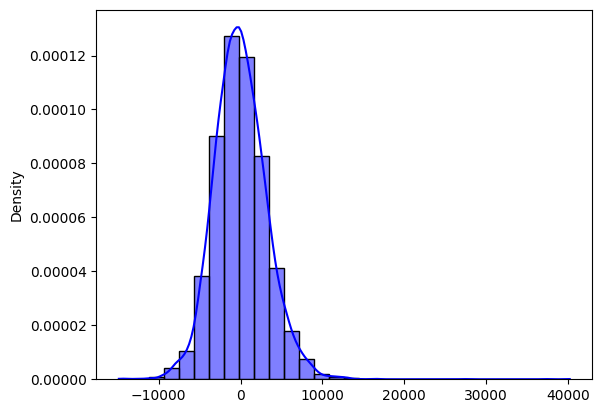

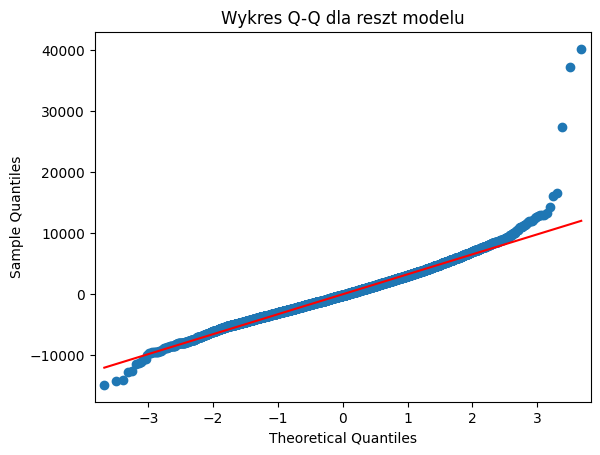

Shapiro-Wilk (próbka): stat=0.9905072589146473, p=0.0026274421777008413
Kołmogorow-Smirnow test: stat=0.03538184143579248, p=0.546600936224434
Jarque-Bera test: stat=17.442665575005012, p=0.00016306970875537815


In [6]:
# Histogram reszt, by sprawdzić wizualnie czy reszty wyglądają na rozkład normalny
sns.histplot(residuals, kde=True, bins=30, stat="density", color="blue")

import statsmodels.api as sm

sm.qqplot(residuals, line='s')
plt.title("Wykres Q-Q dla reszt modelu")
plt.show()

sample_residuals = np.random.choice(residuals, 500, replace=False)  # Próbka 500 reszt

shapiro_test = shapiro(sample_residuals)
print(f"Shapiro-Wilk (próbka): stat={shapiro_test.statistic}, p={shapiro_test.pvalue}")

stat, p_value = kstest(sample_residuals, 'norm', args=(sample_residuals.mean(), sample_residuals.std()))
print(f"Kołmogorow-Smirnow test: stat={stat}, p={p_value}")

stat, p_value, _, _ = jarque_bera(sample_residuals)
print(f"Jarque-Bera test: stat={stat}, p={p_value}")


Teraz na podstawie testów można potwierdzić, że reszty mają rozkład normalny

### 2.3
Wybrać ostateczny podzbiór zmiennych objaśniających (na 2 sposoby):

- Wykorzystać w tym celu metodę krokową wsteczną (bazującą na teście istotności t-studenta). Przedstawić krótko ideę tej metody.

W tej metodzie zaczynamy od pełnego modelu (wszystkie zmienne) i usuwamy najmniej istotne (te z największym p-value w teście t-Studenta), aż zostaną tylko istotne zmienne.
Jeśli p-value zmiennej w teście t-Studenta jest większe niż 0.05, oznacza to, że zmienna nie jest istotna i powinna zostać usunięta.


- Wykorzystać kryteria informacyjne AIC, BIC.

Metoda opiera się na minimalizacji AIC i BIC. W skrócie: im niższe AIC/BIC, tym lepszy model.
Wybieramy kolumnę do usunięcia na podstawie p-value.
Jeśli AIC/BIC się poprawiły (zmniejszyły), zostawiamy zmienną usuniętą i kontynuujemy proces.
Jeśli AIC/BIC się pogorszyły, cofamy usunięcie i testujemy inną zmienną.

In [7]:
# Sprawdzamy p-value dla każdej zmiennej w naszym dotychczaswoym modelu
print(model.pvalues)

# Widzę, że największe p-value ma transmission_Semi-Auto więc je usuwam i buduję model ponownie

const                     0.000000e+00
tax                       1.094083e-37
mpg                       0.000000e+00
engineSize                0.000000e+00
car_age                   0.000000e+00
transmission_Manual       2.870374e-73
transmission_Semi-Auto    5.895875e-01
fuelType_Petrol           2.493727e-26
dtype: float64


In [8]:

X_train_2_3_a = X_train.drop(columns=['transmission_Semi-Auto'])
model = sm.OLS(y_train, X_train_2_3_a).fit()

# Sprawdzamy nowe p-value i ponownie kasuję tą kolumnę z najwięksyzm p-value
print(model.pvalues)

const                   0.000000e+00
tax                     1.053649e-37
mpg                     0.000000e+00
engineSize              0.000000e+00
car_age                 0.000000e+00
transmission_Manual    2.967069e-102
fuelType_Petrol         9.033157e-27
dtype: float64


In [9]:
X_train_2_3_a = X_train_2_3_a.drop(columns=['fuelType_Petrol'])
model = sm.OLS(y_train, X_train_2_3_a).fit()
print(model.pvalues)

const                   0.000000e+00
tax                     1.838814e-30
mpg                     0.000000e+00
engineSize              0.000000e+00
car_age                 0.000000e+00
transmission_Manual    5.611715e-104
dtype: float64


In [10]:
X_train_2_3_a = X_train_2_3_a.drop(columns=['transmission_Manual'])
model = sm.OLS(y_train, X_train_2_3_a).fit()
print(model.pvalues)

const         0.000000e+00
tax           2.077933e-24
mpg           0.000000e+00
engineSize    0.000000e+00
car_age       0.000000e+00
dtype: float64


Na tym etapie sądzę, że ten podzbiór zmiennychh opisujących będzie wystarczający:
- tax
- mpg
- engineSize
- car_age

Teraz przechodzę do drugiej metody AIC, BIC

In [11]:
# Przywracamy pierwotny model
model = sm.OLS(y_train, X_train).fit()

print(model.pvalues)
# Sprawdzamy początkowe wartości AIC i BIC
print(f"AIC: {model.aic}, BIC: {model.bic}")

const                     0.000000e+00
tax                       1.094083e-37
mpg                       0.000000e+00
engineSize                0.000000e+00
car_age                   0.000000e+00
transmission_Manual       2.870374e-73
transmission_Semi-Auto    5.895875e-01
fuelType_Petrol           2.493727e-26
dtype: float64
AIC: 163282.64955068944, BIC: 163339.10892881386


In [12]:
X_train_2_3_b = X_train.drop(columns=['transmission_Semi-Auto'])
model = sm.OLS(y_train, X_train_2_3_b).fit()

# Sprawdzamy nowe p-value i ponownie kasuję tą kolumnę z najwięksyzm p-value
print(model.pvalues)
print(f"AIC: {model.aic}, BIC: {model.bic}")

# AIC i BIC zmieniły się lekko w odpowiednią stronę

const                   0.000000e+00
tax                     1.053649e-37
mpg                     0.000000e+00
engineSize              0.000000e+00
car_age                 0.000000e+00
transmission_Manual    2.967069e-102
fuelType_Petrol         9.033157e-27
dtype: float64
AIC: 163280.9408280782, BIC: 163330.34278393706


In [13]:
X_train_2_3_b = X_train_2_3_b.drop(columns=['fuelType_Petrol'])
model = sm.OLS(y_train, X_train_2_3_b).fit()

print(model.pvalues)
print(f"AIC: {model.aic}, BIC: {model.bic}")

const                   0.000000e+00
tax                     1.838814e-30
mpg                     0.000000e+00
engineSize              0.000000e+00
car_age                 0.000000e+00
transmission_Manual    5.611715e-104
dtype: float64
AIC: 163393.76775864937, BIC: 163436.11229224267


In [14]:
# Wyniki zmieniły się na niekorzyśc więc przywracamy kolumnę i usuwamy inną
X_train_2_3_b['fuelType_Petrol'] = X_train['fuelType_Petrol']

X_train_2_3_b = X_train_2_3_b.drop(columns=['transmission_Manual'])
model = sm.OLS(y_train, X_train_2_3_b).fit()

print(model.pvalues)
print(f"AIC: {model.aic}, BIC: {model.bic}")

const              0.000000e+00
tax                2.892782e-31
mpg                0.000000e+00
engineSize         0.000000e+00
car_age            0.000000e+00
fuelType_Petrol    1.701652e-28
dtype: float64
AIC: 163740.30689844518, BIC: 163782.6514320385


In [15]:
# Wyniki zbów zmieniły się na niekorzyśc więc przywracamy kolumnę i usuwamy inną
X_train_2_3_b['transmission_Manual'] = X_train['transmission_Manual']

X_train_2_3_b = X_train_2_3_b.drop(columns=['tax'])
model = sm.OLS(y_train, X_train_2_3_b).fit()

print(model.pvalues)
print(f"AIC: {model.aic}, BIC: {model.bic}")

const                  0.000000e+00
mpg                    0.000000e+00
engineSize             0.000000e+00
car_age                0.000000e+00
fuelType_Petrol        1.672533e-19
transmission_Manual    7.507210e-96
dtype: float64
AIC: 163443.80388211738, BIC: 163486.1484157107


Wyniki na korzyść, usuwaliśmy już kolumny z największymi p-value, reszta ma sporo mniejsza wartości, więc to będzie nasz wynikowy zbiór zmiennych opisujących
- mpg
- engineSize
- car_age
- fuelType_Petrol
- transmission_Manual

### 2.4
Dokonać dalszej weryfikacji modelu:
a) Przeprowadzić testy istotności poszczególnych zmiennych objaśniających (testem t-Studenta).
Test t-Studenta dla pojedynczych zmiennych objaśniających jest już przeprowadzony w wynikach summary() modelu OLS, jest to kolumna P>|t|.
Sprawdzamy, które zmienne mają istotność statystyczną (p-value < 0.05).
Wszystkie zmienne są istotne (p-value < 0.05), więc każda z nich ma wpływ na cenę samochodu.

b) Przeprowadzając odpowiedni test ocenić istotność wszystkich zmiennych objaśniających.
Bierzemy pod uwagę wynik testu F-statystyki i jego p-value

Hipotezy testu
**H0**: Wszystkie współczynniki regresji (oprócz wyrazu wolnego) są równe 0, czyli żadna zmienna objaśniająca nie wpływa istotnie na cenę.
**H1**: Przynajmniej jedna zmienna objaśniająca istotnie wpływa na cenę.

F-statistic:  9380.  
Prob (F-statistic): 0.00

- Bardzo wysoka wartość F-statystyki (9380) oznacza, że model dobrze dopasowuje się do danych.
- p-value = 0.00 (czyli < 0.05) → Odrzucamy H0 → Przynajmniej jedna zmienna objaśniająca istotnie wpływa na cenę samochodu.

c) Zinterpretować wartość współczynnika determinacji. Czy można stwierdzić, że wielkość tego parametru jest statystycznie istotna?
R-squared (R²) = 0.814: Oznacza to, że 81.4% zmienności zmiennej zależnej (price) jest wyjaśnione przez zmienne objaśniające w modelu.

d) Sprawdzić, czy model jest koincydentny.
Test White’a (heteroskedastyczność):
stat=5552.228549035446, p-value=0.0

Hipotezy testu
**H0**: Brak heteroskedastyczności (wariancja reszt jest stała).
**H1**: Obecna jest heteroskedastyczność (wariancja reszt nie jest stała).

Ponieważ p-value < 0.05, odrzucamy hipotezę zerową, co oznacza, że występuje heteroskedastyczność.
Może to sugerować, że model jest błędnie wyspecyfikowany lub, że niektóre zmienne wpływają na wariancję reszt.

e) Sprawdzić, czy w modelu nie zachodzi zjawisko współliniowości (za pomocą statystyki VIF).
VIF bada współliniowość (czyli silną korelację między zmiennymi objaśniającymi).

Hipotezy testu
**H0**: Brak współliniowości.
**H1**: Istnieje silna współliniowość.

Wszytskie wyniki są < 10>, więc nie odrzucamy H0. Brak współliniowości w modelu.

f) Zbadać stabilność postaci funkcyjnej modelu (test RESET).

Statystyka: 21515.46
p-value: 0.0

**H0**: Postać funkcyjna modelu jest stabilna.
**H1**: Postać funkcyjna modelu nie jest stabilna.

Bardzo niskie p-value (0.0) oznacza, że hipoteza zerowa o poprawnej postaci modelu zostaje odrzucona.
To sugeruje, że w modelu mogą występować nieliniowości lub brakujące zmienne.

g) Zbadać stabilność parametrów modelu (test Chowa).

Statystyka F = 4.0562
Wartość krytyczna F = 2.2150

**H0**: 𝛼 = 𝛽 = 𝛿 (parametry modelu są stabilne)
**H1**: Parametry modelu nie są stabilne

F > F_krytyczne, więc odrzucamy hipotezę zerową H0.

Parametry modelu nie są stabilne. Oznacza to, że zależności między zmiennymi zmieniają się w czasie lub między grupami danych.

h) Zbadać liniowość modelu ekonometrycznego (test liczby serii).

Statystyka: -0.0776
p-value: 0.9381

**H0**: Postać modelu jest dobrze dobrana, model jest liniowy
**H1**: ~𝐻0

Wysokie p-value (0.9381) oznacza brak podstaw do odrzucenia H0.
Oznacza to, że reszty są losowe i nie ma dowodów na nieliniowość modelu.

In [23]:
# Używam finalnego modelu, który uzyskałem za pomocą metody krokowej wstecznej
model = sm.OLS(y_train, X_train_2_3_a).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.814
Model:                            OLS   Adj. R-squared:                  0.814
Method:                 Least Squares   F-statistic:                     9380.
Date:                Fri, 28 Mar 2025   Prob (F-statistic):               0.00
Time:                        00:33:13   Log-Likelihood:                -81926.
No. Observations:                8582   AIC:                         1.639e+05
Df Residuals:                    8577   BIC:                         1.639e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       4.256e+04    331.202    128.501      0.0

In [17]:
# 2.4 c
import statsmodels.api as sm
import numpy as np
import pandas as pd
from statsmodels.stats.anova import anova_lm

# Model podstawowy: tylko 'tax'
X_basic = df[['tax']]
X_basic = sm.add_constant(X_basic)  # Dodaje stałą
y = df['price']

# Model rozszerzony: 'tax', 'mpg', 'engineSize'
X_extended = df[['tax', 'mpg', 'engineSize']]
X_extended = sm.add_constant(X_extended)  # Dodaje

# Budowanie modeli
model_basic = sm.OLS(y, X_basic).fit()  # Estymacja modelu podstawowego
model_extended = sm.OLS(y, X_extended).fit()  # Estymacja modelu rozszerzonego

# Obliczam reszty
residuals_basic = model_basic.resid
residuals_extended = model_extended.resid

# Obliczam statystykę F dla testu Walda
# F-statystyka dla testu Wald to różnica w sumie kwadratów reszt (RSS) z dwóch modeli
rss_basic = np.sum(residuals_basic ** 2)
rss_extended = np.sum(residuals_extended ** 2)
n = len(y)  # liczba obserwacji
k_basic = X_basic.shape[1]  # liczba zmiennych w modelu podstawowym
k_extended = X_extended.shape[1]  # liczba zmiennych w modelu rozszerzonym
m = k_extended - k_basic  # liczba dodanych zmiennych

# Statystyka F
F_statistic = ((rss_basic - rss_extended) / m) / (rss_extended / (n - k_extended))

# Obliczam wartość krytyczną F (rozklad F-Snedecora)
from scipy.stats import f

# Stopnie swobody
df1 = m
df2 = n - k_extended
F_critical = f.ppf(0.95, df1, df2)

print(f"F-statystyka: {F_statistic}")
print(f"Wartość krytyczna F: {F_critical}")

if F_statistic > F_critical:
    print("Odrzucamy hipotezę zerową, zmienne objaśniające w modelu rozszerzonym są istotne.")
else:
    print("Nie odrzucamy hipotezy zerowej, zmienne objaśniające w modelu rozszerzonym nie są istotne.")

F-statystyka: 4188.752388376381
Wartość krytyczna F: 2.9966739744007773
Odrzucamy hipotezę zerową, zmienne objaśniające w modelu rozszerzonym są istotne.


In [18]:
# 2.4 d
# Test koincydencji (White'a). Sprawdza, czy wariancja błędów jest stała.
import statsmodels.stats.diagnostic as smd

white_test = smd.het_white(residuals, X_train)
print(f"Test White'a: stat={white_test[0]}, p-value={white_test[1]}")

Test White'a: stat=5552.228549035446, p-value=0.0


In [19]:
# 2.4 e
# Jeśli VIF > 10, to istnieje silna współliniowość.
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_data = pd.DataFrame()
vif_data["Variable"] = X_train.columns
vif_data["VIF"] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]

print(vif_data)
# nie zachodzi zjawisko współliniowości

                 Variable         VIF
0                   const  155.821737
1                     tax    2.042462
2                     mpg    3.499514
3              engineSize    2.185442
4                 car_age    1.530164
5     transmission_Manual    2.016981
6  transmission_Semi-Auto    1.598297
7         fuelType_Petrol    1.986805


In [20]:
# 2.4 f
# Test RESET (sprawdzenie stabilności modelu)
from statsmodels.stats.diagnostic import linear_reset

reset_test = linear_reset(model)
print(reset_test)

<Wald test (chi2): statistic=21515.45772600513, p-value=0.0, df_denom=2>


In [21]:
# 2.4 g
# Test Chowa (stabilność parametrów modelu)
# from statsmodels.stats.diagnostic import breaks_hansen

# chow_test = breaks_hansen(model)
# print(chow_test)

# Szacuję model dla całego zbioru
RSS_full = np.sum(model.resid ** 2)  # Resztowa suma kwadratów dla pełnego modelu

# Dzielę danyce na dwa
split_point = len(df) // 2
X1, X2 = X_train_2_3_a.iloc[:split_point, :], X_train_2_3_a.iloc[split_point:, :]
y1, y2 = y_train.iloc[:split_point], y_train.iloc[split_point:]

# Szacuję modele
model_1 = sm.OLS(y1, X1).fit()
model_2 = sm.OLS(y2, X2).fit()

RSS_1 = np.sum(model_1.resid ** 2)  # Resztowa suma kwadratów dla 1 przedziału
RSS_2 = np.sum(model_2.resid ** 2)  # Resztowa suma kwadratów dla 2 przedziału

# Obliczam statystykę F
k = X_train_2_3_a.shape[1] - 1  # Liczba zmiennych objaśniających
n = len(df)

F_stat = ((RSS_full - (RSS_1 + RSS_2)) / (k + 1)) / ((RSS_1 + RSS_2) / (n - 2 * (k + 1)))

# Obliczam wartość krytyczną F
alpha = 0.05
F_critical = f.ppf(1 - alpha, dfn=k + 1, dfd=n - 2 * (k + 1))

print(f"F={F_stat:.4f}, Wartość krytyczna F={F_critical:.4f}")

if F_stat > F_critical:
    print(f"Odrzucamy H0: parametry modelu NIE są stabilne")
else:
    print(f"Brak podstaw do odrzucenia H0: parametry modelu są stabilne")

F=4.0562, Wartość krytyczna F=2.2150
Odrzucamy H0: parametry modelu NIE są stabilne


In [22]:
# 2.4 h
# Test liczby serii (sprawdzenie liniowości)
from statsmodels.sandbox.stats.runs import runstest_1samp

runs_test = runstest_1samp(residuals)
print(f"Test liczby serii: stat={runs_test[0]}, p-value={runs_test[1]}")

Test liczby serii: stat=-0.0775979062185418, p-value=0.9381479079564082
